In [1]:
%matplotlib inline
import pandas
import os
import collections
import numpy

pandas.set_option("display.max_rows", 500)


from train_test import find_files, parse_dates, load_series, load_data, separate_output

path = "../data/v2/train_set/"
power_data = load_series(find_files(path, "power"), resample_interval="1H")

Using Theano backend.


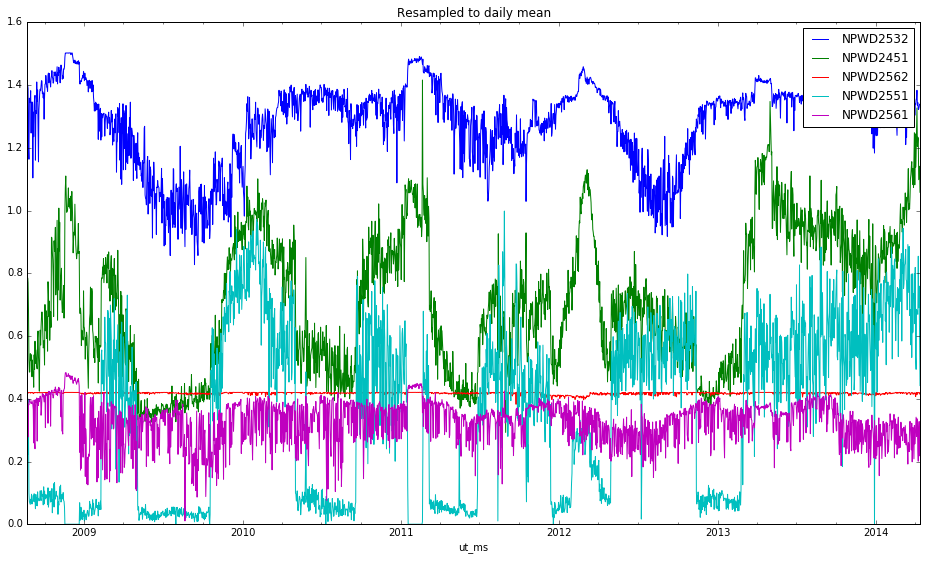

In [2]:
col_weights = power_data.mean(axis=0) #+ power_data.std(axis=0)
col_weights.sort_values(ascending=False)

ax = power_data[col_weights.sort_values(ascending=False)[:5].index].resample("1D").mean().plot(figsize=(16, 9))
ax.set_title("Resampled to daily mean")
ax.legend(loc="upper right")
ax

In [3]:
saaf_data = load_series(find_files(path, "saaf"))
evtf_data = load_series(find_files(path, "evtf"))
dmop_data = load_series(find_files(path, "dmop"))
ftl_data = load_series(find_files(path, "ftl"))

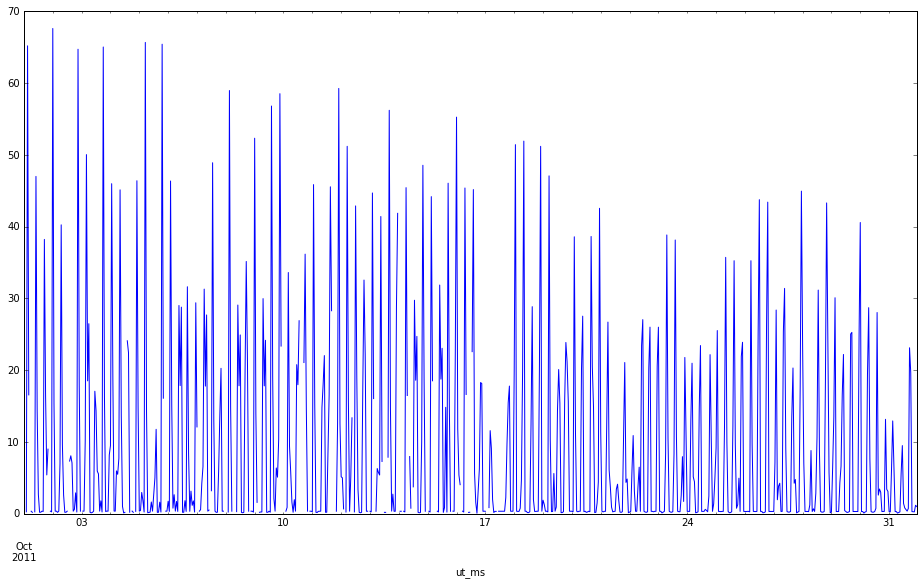

In [4]:
saaf_data.sa["2011-10"].resample("1H").mean().plot(figsize=(16,9))

In [5]:
evtf_data.description.str.extract("(\\w+_[AL]OS_\\d+)", expand=False).value_counts().sort_index()

BLK_AOS_00    2064
BLK_AOS_05    2064
BLK_AOS_10    2015
BLK_LOS_00    2063
BLK_LOS_05    2063
BLK_LOS_10    2015
CAN_AOS_05    2063
CAN_AOS_07     490
CAN_AOS_08     727
CAN_AOS_09     387
CAN_AOS_10    2302
CAN_AOS_11     220
CAN_LOS_05    2064
CAN_LOS_06    2064
CAN_LOS_10    2064
CEB_AOS_02     698
CEB_AOS_03     914
CEB_AOS_04     452
CEB_AOS_05    2064
CEB_AOS_10    2064
CEB_LOS_02     165
CEB_LOS_03    1094
CEB_LOS_04     495
CEB_LOS_05    2372
CEB_LOS_10    2063
GDS_AOS_05    2063
GDS_AOS_06    2063
GDS_AOS_10    2063
GDS_LOS_05    2064
GDS_LOS_06    2064
GDS_LOS_10    2064
KLZ_AOS_00    2064
KLZ_AOS_05    2064
KLZ_AOS_10    1904
KLZ_LOS_00    2063
KLZ_LOS_05    2063
KLZ_LOS_10    1903
MAD_AOS_05    2064
MAD_AOS_06    2064
MAD_AOS_10    2064
MAD_LOS_05    2063
MAD_LOS_07     279
MAD_LOS_08    1049
MAD_LOS_09     735
MAD_LOS_10    2063
MLG_AOS_00    1254
MLG_AOS_01     497
MLG_AOS_02     313
MLG_AOS_05    2064
MLG_AOS_10    2064
MLG_LOS_01     577
MLG_LOS_02     880
MLG_LOS_03  

In [6]:
counts = evtf_data.description.str.extract("(\\w+_[AL]OS_\\d+)", expand=False).value_counts()

for desc, count in counts.sort_index().iteritems():
    if count > 1000:
        aos_dates = pandas.Series(evtf_data[evtf_data.description.str.contains(desc)].index)
        print desc, aos_dates.diff().mean(), " +/- ", aos_dates.diff().std()


BLK_AOS_00 0 days 23:58:11.862821  +/-  0 days 00:01:38.156307
BLK_AOS_05 0 days 23:58:11.879301  +/-  0 days 00:01:40.045326
BLK_AOS_10 1 days 00:33:11.374379  +/-  0 days 17:51:41.371002
BLK_LOS_00 0 days 23:58:10.407856  +/-  0 days 00:01:49.813175
BLK_LOS_05 0 days 23:58:10.388457  +/-  0 days 00:01:52.100425
BLK_LOS_10 1 days 00:32:26.917576  +/-  0 days 17:49:17.045591
CAN_AOS_05 0 days 23:58:10.781280  +/-  0 days 00:01:25.347576
CAN_AOS_10 0 days 21:28:47.936983  +/-  0 days 07:18:23.471992
CAN_LOS_05 0 days 23:58:11.443044  +/-  0 days 00:01:18.500752
CAN_LOS_06 0 days 23:58:11.444013  +/-  0 days 00:01:18.547270
CAN_LOS_10 0 days 23:58:11.448860  +/-  0 days 00:01:18.834761
CEB_AOS_05 0 days 23:58:11.530780  +/-  0 days 00:01:20.930709
CEB_AOS_10 0 days 23:58:11.541444  +/-  0 days 00:01:21.508237
CEB_LOS_03 1 days 16:18:43.240622  +/-  7 days 15:25:03.129848
CEB_LOS_05 0 days 20:50:44.944327  +/-  0 days 08:03:47.054932
CEB_LOS_10 0 days 23:58:10.696411  +/-  0 days 00:01:29

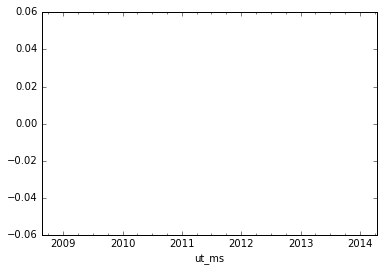

In [7]:
# for each power, find the previous MSL_AOS_10 event and assign that
aos = evtf_data[evtf_data.description.str.contains("MRB_LOS_10")].copy()
aos["date"] = aos.index
# print aos.head(50)
aos = aos.reindex(index=power_data.index, method="ffill")
aos_next = aos.reindex(index=power_data.index, method="bfill")
aos["date_next"] = aos_next.date
aos["delta"] = (aos.index - aos.date).dt.total_seconds() / (aos.date_next - aos.date).dt.total_seconds()

aos.delta.plot()

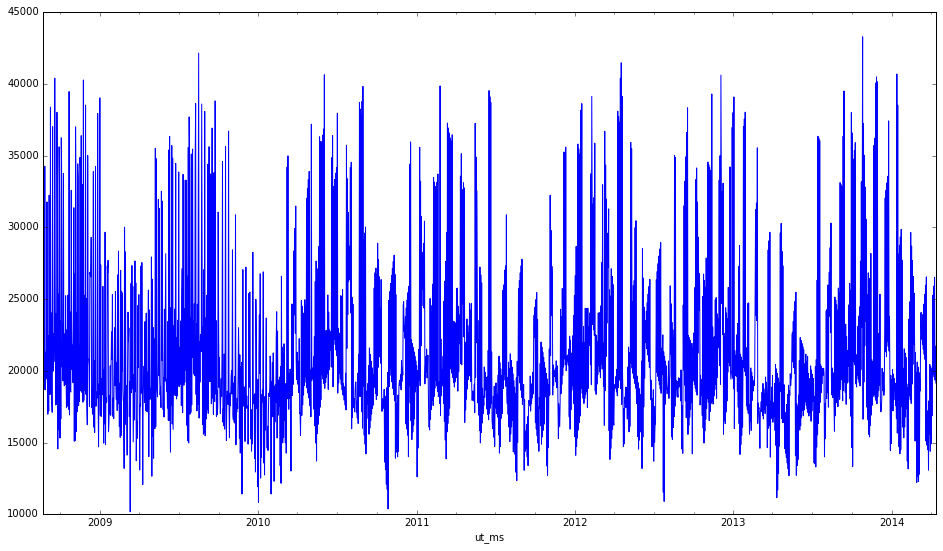

In [8]:
def time_since_last_event(event_data, index):
    event_dates = pandas.Series(index=event_data.index, data=event_data.index, name="date")
    event_dates = event_dates.reindex(index, method="ffill")
    deltas = event_dates.index - event_dates
    return deltas.fillna(0).dt.total_seconds()

time_since_last_event(evtf_data[evtf_data.description.str.contains("MRB_AOS_00")], power_data.index).resample("1D").mean().plot(figsize=(16, 9))

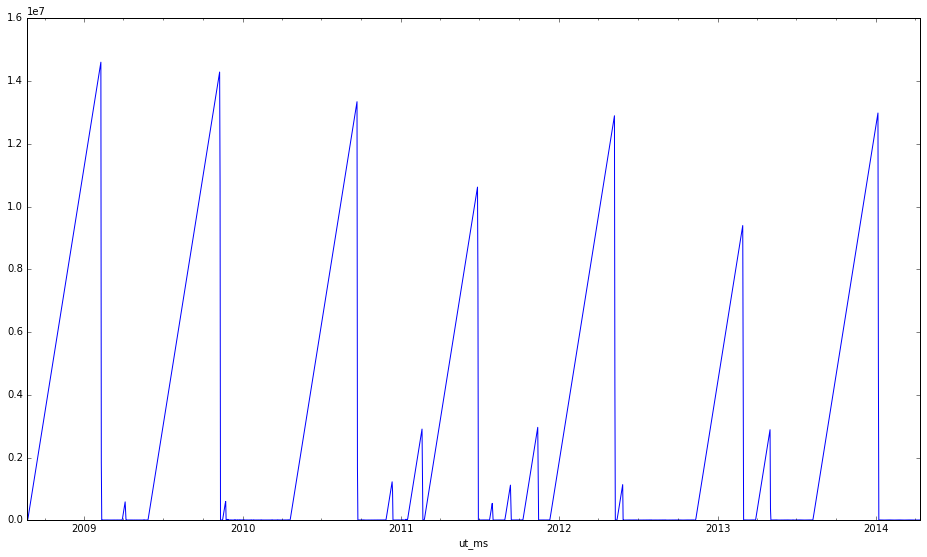

In [9]:
time_since_last_event(dmop_data[dmop_data.subsystem.str.contains("PENS")], power_data.index).resample("1D").mean().plot(figsize=(16, 9))

In [10]:
dmop_data.subsystem.value_counts()[:20]

AAAAF56A1    20035
AACFE91A     19493
APSF28A1     18312
AACFE03A     18227
APSF38A1     15611
AAAAF20E1    13440
AVVV02A0     10073
AVVV03B0      9774
AAAAF20C1     9205
AMMMF10A0     8938
AACFE05A      8394
AAAAF23G1     6450
AAAAF57A1     5532
AAAAF60A1     5530
AMMMF18A0     5029
AMMMF19A0     5004
APSF32A1      4893
APSF50A2      4854
AACFM07A      4634
AACFM06A      4600
Name: subsystem, dtype: int64

In [11]:
lt_data = load_series(find_files(path, "ltdata"))
lt_data.describe()

,sunmars_km,earthmars_km,sunmarsearthangle_deg,solarconstantmars,eclipseduration_min,occultationduration_min
count,2.061000e+03,2.061000e+03,2061.000000,2061.000000,2061.000000,2061.000000
mean,2.289354e+08,2.715726e+08,22.552500,590.958510,16.454731,18.068260
std,1.502282e+07,8.800971e+07,11.954585,78.516293,18.362685,20.537767
min,2.066449e+08,9.242161e+07,0.280288,492.116468,0.000000,0.000000
25%,2.139517e+08,2.012069e+08,12.117072,513.963102,0.000000,0.000000
50%,2.298804e+08,3.014157e+08,23.891058,578.492159,5.183333,11.100000
75%,2.438848e+08,3.493427e+08,33.886943,667.836542,34.516667,33.550000
max,2.492395e+08,3.744911e+08,39.859552,715.899348,55.450000,87.733333


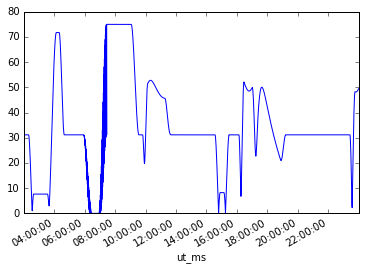

In [12]:
saaf_data.sx["2014-01-02"].plot()

In [13]:
fine_power = load_series(find_files(path, "power"))
fine_power.describe()

,NPWD2372,NPWD2401,NPWD2402,NPWD2451,NPWD2471,NPWD2472,NPWD2481,NPWD2482,NPWD2491,NPWD2501,...,NPWD2792,NPWD2801,NPWD2802,NPWD2821,NPWD2851,NPWD2852,NPWD2871,NPWD2872,NPWD2881,NPWD2882
count,5.402201e+06,5.402201e+06,5.402201e+06,5.402201e+06,5.402201e+06,5.402201e+06,5.402201e+06,5.402201e+06,5.402201e+06,5.402201e+06,...,5.402201e+06,5.402201e+06,5.402201e+06,5.402201e+06,5.402201e+06,5.402201e+06,5.402201e+06,5.402201e+06,5.402201e+06,5.402201e+06
mean,1.265718e-01,1.673596e-03,1.753386e-01,7.063870e-01,7.386059e-04,1.236624e-03,2.436808e-03,2.035755e-03,2.006293e-01,5.295355e-03,...,9.864580e-04,1.535510e-03,1.334152e-01,5.780211e-03,2.973559e-01,5.276393e-04,5.216509e-04,7.450369e-04,4.484993e-02,3.373378e-03
std,1.753571e-01,5.739167e-03,2.896129e-03,8.745314e-01,6.749120e-05,1.432615e-03,2.597007e-02,5.878030e-03,2.134436e-01,1.302760e-02,...,1.009873e-03,1.321280e-04,1.095240e-01,5.033459e-04,3.256682e-01,8.290170e-04,4.485661e-05,6.333928e-05,1.604208e-01,2.908105e-04
min,1.456800e-03,1.179110e-03,1.612890e-03,4.012400e-03,5.714290e-04,5.005000e-04,4.435560e-04,1.461600e-03,1.612890e-03,4.022180e-03,...,4.426670e-04,1.179110e-03,1.061600e-03,4.437780e-03,3.985600e-03,4.012000e-04,3.988000e-04,5.714290e-04,5.165500e-03,2.582000e-03
25%,1.821000e-03,1.473890e-03,1.721730e-01,5.015500e-03,7.142860e-04,6.256250e-04,5.544440e-04,1.827000e-03,2.016110e-03,5.027730e-03,...,5.533330e-04,1.473890e-03,2.388600e-03,5.547220e-03,6.976000e-02,5.015000e-04,4.985000e-04,7.142860e-04,6.456870e-03,3.227500e-03
50%,1.821000e-03,1.473890e-03,1.774400e-01,6.018600e-03,7.142860e-04,1.001000e-03,5.544440e-04,1.827000e-03,2.419330e-03,5.027730e-03,...,8.853330e-04,1.473890e-03,1.562960e-01,5.547220e-03,6.976000e-02,5.015000e-04,4.985000e-04,7.142860e-04,6.456870e-03,3.227500e-03
75%,3.738720e-01,1.473890e-03,1.774400e-01,1.112890e+00,7.142860e-04,1.001000e-03,5.544440e-04,1.827000e-03,4.302560e-01,5.027730e-03,...,9.960000e-04,1.473890e-03,1.615940e-01,5.547220e-03,5.680600e-01,6.018000e-04,4.985000e-04,7.142860e-04,7.748250e-03,3.227500e-03
max,3.791610e-01,3.311290e-01,1.827070e-01,2.215750e+00,8.571430e-04,6.247000e-03,4.099450e-01,3.329360e-01,4.355230e-01,2.164860e+00,...,1.695400e-01,2.653000e-03,3.311300e-01,6.656670e-03,1.465000e+00,1.116750e+00,5.982000e-04,8.571430e-04,7.336410e-01,3.873000e-03


In [14]:
num_values = dict()
for col in fine_power.columns:
    num_values[col] = len(fine_power[col].value_counts())

from operator import itemgetter
for col, value_count in sorted(num_values.items(), key=itemgetter(1), reverse=True):
    print col, value_count

NPWD2551 51
NPWD2851 40
NPWD2531 35
NPWD2532 31
NPWD2721 25
NPWD2562 23
NPWD2451 22
NPWD2802 21
NPWD2742 20
NPWD2771 15
NPWD2791 13
NPWD2482 12
NPWD2401 12
NPWD2852 11
NPWD2372 9
NPWD2402 9
NPWD2501 8
NPWD2481 8
NPWD2792 8
NPWD2491 8
NPWD2561 8
NPWD2722 8
NPWD2881 7
NPWD2472 6
NPWD2801 4
NPWD2871 3
NPWD2872 3
NPWD2882 3
NPWD2552 3
NPWD2821 3
NPWD2471 3
NPWD2691 3
NPWD2692 3


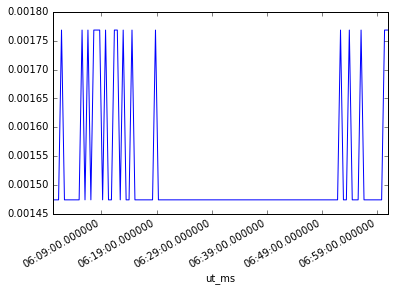

In [15]:
fine_power.NPWD2801["2010-10-01 06:00":"2010-10-01 07:00"].plot()

In [19]:
event_counts = evtf_data[evtf_data.description.str.contains("UMBRA")].description.value_counts()

from train_test import get_evtf_ranges

for event_name in event_counts.index[event_counts.index.str.contains("START")]:
    event_name, _ = event_name.rsplit("_", 1)
    
    ranges = get_evtf_ranges(evtf_data, event_name)
    
    print("Mean delta for ", event_name, sum((e.end - e.start).total_seconds() / 60. for e in ranges) / len(ranges))


('Mean delta for ', 'MAR_PENUMBRA', 32.44261226010813)
('Mean delta for ', 'MAR_UMBRA', 32.18780350084706)
('Mean delta for ', 'PHO_PENUMBRA', 0.7804597701149427)
('Mean delta for ', 'DEI_PENUMBRA', 2.2590909090909084)
('Mean delta for ', 'PHO_UMBRA', 0.2592592592592593)
('Mean delta for ', 'DEI_UMBRA', 0.7333333333333333)
